pip install statsmodels==0.9.0rc1

If you are facing any issues

In [1]:
# grid search holt winter's exponential smoothing
from math import sqrt
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed
from warnings import catch_warnings
from warnings import filterwarnings
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error
from numpy import array
from pandas import read_csv
import matplotlib
# %matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import csv
import os

In [2]:
# one-step Holt Winter’s Exponential Smoothing forecast
def exp_smoothing_forecast(history, config):
    t,d,s,p,b,r = config
    # define model
    history = array(history)
    model = ExponentialSmoothing(history, trend=t, damped=d, seasonal=s, seasonal_periods=p)
    # fit model
    model_fit = model.fit(optimized=True, use_boxcox=b, remove_bias=r)
    # make one step forecast
    yhat = model_fit.predict(len(history), len(history))
    return yhat[0]

In [3]:
# root mean squared error or rmse
def measure_rmse(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))

In [4]:
# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
    return data[:-n_test], data[-n_test:]

In [5]:
# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
    predictions = list()
    # split dataset
    train, test = train_test_split(data, n_test)
    # seed history with training dataset
    history = [x for x in train]
    # step over each time-step in the test set
    for i in range(len(test)):
        # fit model and make forecast for history
        yhat = exp_smoothing_forecast(history, cfg)
        # store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        history.append(test[i])
    # estimate prediction error
    error = measure_rmse(test, predictions)
    return error

In [6]:
# score a model, return None on failure
def score_model(data, n_test, cfg, debug=False):
    result = None
    # convert config to a key
    key = str(cfg)
#     result = walk_forward_validation(data, n_test, cfg)
    # show all warnings and fail on exception if debugging
    if debug:
        result = walk_forward_validation(data, n_test, cfg)
    else:
        # one failure during model validation suggests an unstable config
        try:
            # never show warnings when grid searching, too noisy
            with catch_warnings():
                filterwarnings("ignore")
                result = walk_forward_validation(data, n_test, cfg)
                
        except:
            error = None
#     print(result)
    # check for an interesting result
    if result is not None:
        print(' > Model[%s] %.3f' % (key, result))
    return (key, result)

In [7]:
# grid search configs
def grid_search(data, cfg_list, n_test, parallel=True):
    
    scores = None
    if parallel:
        # execute configs in parallel
        executor = Parallel(n_jobs=cpu_count(), backend='multiprocessing')
        tasks = (delayed(score_model)(data, n_test, cfg) for cfg in cfg_list)
        scores = executor(tasks)
    else:
        scores = [score_model(data, n_test, cfg) for cfg in cfg_list]
    # remove empty results
    scores = [r for r in scores if r[1] != None]
#     print(scores)
    # sort configs by error, asc
    scores.sort(key=lambda tup: tup[1])
    return scores

In [8]:
# create a set of exponential smoothing configs to try
def exp_smoothing_configs(seasonal=[None]):
    models = list()
    # define config lists
    t_params = ['add', 'mul', None]
    d_params = [True, False]
    s_params = ['add', 'mul', None]
    p_params = seasonal
    b_params = [True, False]
    r_params = [True, False]
    # create config instances
    for t in t_params:
        for d in d_params:
            for s in s_params:
                for p in p_params:
                    for b in b_params:
                        for r in r_params:
                            cfg = [t,d,s,p,b,r]
                            models.append(cfg)
    return models

In [9]:
# walk-forward validation for univariate data
def walk_forward_validationer(data, n_test, cfg):
    predictions = list()
    # split dataset
    train, test = train_test_split(data, n_test)
    # seed history with training dataset
    history = [x for x in train]
    # step over each time-step in the test set
    for i in range(len(test)):
        # fit model and make forecast for history
        yhat = exp_smoothing_forecast(history, cfg)
        # store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        history.append(test[i])
    # estimate prediction error
#     error = measure_rmse(test, predictions)
    return test,predictions

In [10]:
# load dataset
cwd = os.getcwd()
file = cwd+'/Sample-Data/28A18305A90B_20180315003638.csv'
Data = pd.read_csv(file,skiprows=5)
df= Data['DATE'].apply(lambda x : pd.to_datetime(str(x)))
df = df.dt.hour*3600+df.dt.minute*60+df.dt.second+df.dt.microsecond/10**6
Data['DATE'] = df.values-df.values[0]
Data = Data.drop(['//ARTIFACT','NUM'],axis=1)
Data

,DATE,ACC_X,ACC_Y,ACC_Z,EOG_L1,EOG_R1,EOG_L2,EOG_R2,EOG_H1,EOG_H2,EOG_V1,EOG_V2
0,0.00,-1836,11827,-11291,-60,90,-56,100,-150,-156,-15,-22
1,0.02,-1857,11750,-11220,-55,98,-56,90,-153,-146,-21,-17
2,0.04,-1806,11621,-11204,-52,96,-65,76,-148,-141,-22,-5
3,0.06,-1889,11603,-11279,-67,64,-61,63,-131,-124,1,-1
4,0.08,-1899,11551,-11354,-61,58,-62,66,-119,-128,1,-2
5,0.10,-1855,11521,-11358,-76,52,-91,39,-128,-130,12,26
6,0.12,-1823,11535,-11255,-94,34,-99,28,-128,-127,30,35
7,0.14,-1793,11591,-11360,-93,40,-95,27,-133,-122,26,34
8,0.16,-1810,11554,-11400,-99,20,-99,21,-119,-120,39,39
9,0.18,-1840,11579,-11379,-97,21,-94,26,-118,-120,38,34


In [11]:
# series = read_csv('daily-total-female-births.csv', header=0, index_col=0)
data = Data.EOG_V1.values#series.values
# data split
n_test = 200#int(len(data)*.1)
# model configs
cfg_list = exp_smoothing_configs()
# grid search
scores = grid_search(data, cfg_list, n_test)
print('done')
# list top 3 configs
for cfg, error in scores[:3]:
    print(cfg, error)

 > Model[[None, False, None, None, False, True]] 31.029
 > Model[[None, False, None, None, False, False]] 31.022
 > Model[['add', True, None, None, False, True]] 29.221
 > Model[['add', True, None, None, False, False]] 29.213
 > Model[['add', False, None, None, False, True]] 34.413
 > Model[['add', False, None, None, False, False]] 34.405
done
['add', True, None, None, False, False] 29.21339164037167
['add', True, None, None, False, True] 29.22067462865082
[None, False, None, None, False, False] 31.021524785219697


In [12]:
a = ['add', True, None, None, False, False]

In [13]:
# data = Data.EOG_V1.values
aa,bb = walk_forward_validationer(data, 200, a)

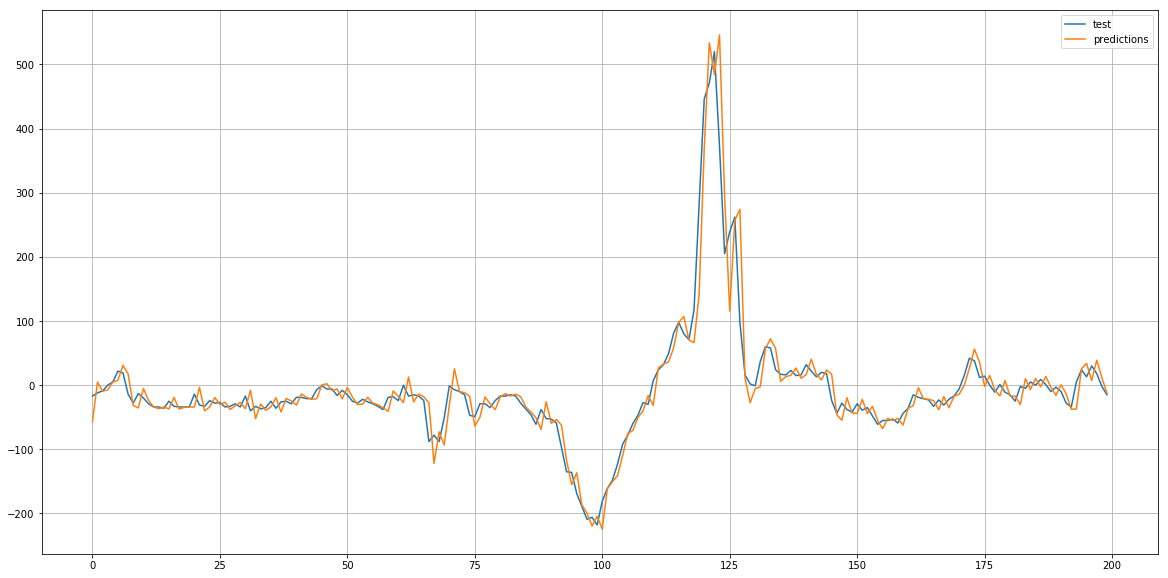

In [14]:
plt.figure(figsize=(20,10))
plt.plot(aa)
plt.plot(bb)
plt.grid()
plt.legend(['test','predictions'],loc='upper right')
plt.show()